In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Reshape
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import Conv1D, Input, LSTM, Activation, Dense, Average
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization

import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error

from tensorflow.keras.layers import BatchNormalization
import cv2
from tensorflow.keras.optimizers import Adam , Adadelta

warnings.filterwarnings('ignore')

In [ ]:
df_train=pd.read_csv('../input/heartbeat/mitbih_train.csv' , header=None)
df_test=pd.read_csv('../input/heartbeat/mitbih_train.csv' , header=None )
display_test = pd.read_csv("../input/xal-test/display_XAI.csv" , header = None)

In [ ]:
df_train.rename(columns={187:"Class"}, inplace=True)
df_test.rename(columns={187:"Class"}, inplace=True)
display_test.rename(columns={187:"Class"}, inplace=True)

In [ ]:
mapping = {     0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular',
               4. : 'Unclassifiable beat'}

In [ ]:
df_train['label'] = df_train.iloc[:, -1].map(mapping)
df_test['label'] = df_test.iloc[:, -1].map(mapping)
display_test['label'] = display_test.iloc[:, -1].map(mapping)


In [ ]:
label_train = df_train['label'].unique()
label_test = df_test['label'].unique()

In [ ]:

df_1=df_train[df_train['Class']==1]
df_2=df_train[df_train['Class']==2]
df_3=df_train[df_train['Class']==3]
df_4=df_train[df_train['Class']==4]
df_0=(df_train[df_train['Class']==0]).sample(n=20000,random_state=42)

df_train=pd.concat([df_1,df_0,df_2,df_3,df_4])

In [ ]:
X_train=df_train.iloc[:,:186].values
X_test=df_test.iloc[:,:186].values
X_display = display_test.iloc[: , :186].values

In [ ]:
X_train.shape

(35083, 186)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train,df_train["Class"])

In [ ]:
from collections import Counter

counter = Counter(y_train)
print(counter)

Counter({1.0: 20000, 0.0: 20000, 2.0: 20000, 3.0: 20000, 4.0: 20000})


In [ ]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_display = X_display.reshape(len(X_display), X_display.shape[1],1)

In [ ]:
X_train.shape

(100000, 186, 1)

In [ ]:
target_train=y_train
target_test=df_test["Class"]
target_display = display_test["Class"]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
y_display=to_categorical(target_display)

In [ ]:
from sklearn.model_selection import train_test_split
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [3]:
!pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, LSTM, Activation, Dense, Average
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from attention import Attention

In [9]:
inputs_1 = Input(shape = (186,1))

x = LSTM(64, return_sequences =  True)(inputs_1)

x = Attention(32)(x)

x = Conv1D(64 ,kernel_size=(5,))(inputs_1)
x = Activation('relu')(x)

x = Conv1D(64 ,kernel_size=(5,))(x)
x = Activation('relu')(x)

x = Conv1D(64 ,kernel_size=(5,))(x)
x = Activation('relu')(x)
x=Flatten()(x)


x = Dense(512)(x)
x = Activation('relu')(x)
x = Dense(256)(x)
x = Activation('relu')(x)

outputs = Dense(5, activation = 'softmax')(x)
model = tf.keras.models.Model(inputs = inputs_1, outputs = outputs)


In [7]:
import tensorflow as tf

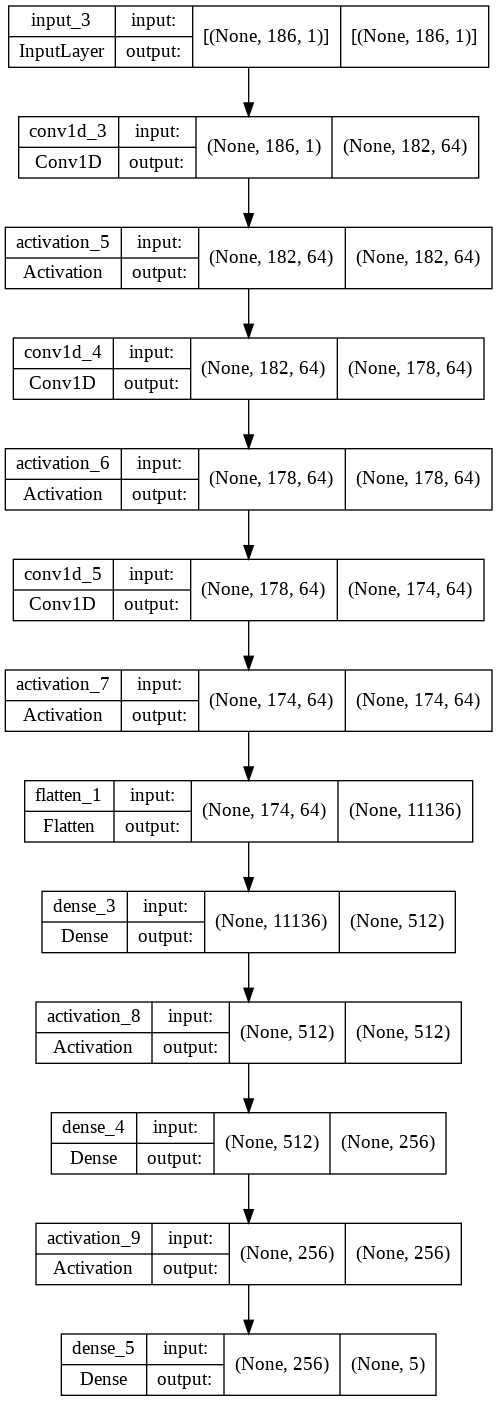

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 186, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           384       
_________________________________________________________________
activation (Activation)      (None, 182, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 178, 64)           20544     
_________________________________________________________________
activation_1 (Activation)    (None, 178, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 174, 64)           20544     
_________________________________________________________________
activation_2 (Activation)    (None, 174, 64)           0     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam' , metrics = ['accuracy']) 

In [ ]:
my_callbacks = [
#    keras.callbacks.EarlyStopping(monitor='val_loss' , patience=8),
    keras.callbacks.ModelCheckpoint(filepath='attention_model_.h5' , monitor = 'val_loss' , save_best_only=True),
    
]

In [ ]:
history=model.fit(X_train, y_train,epochs=75,callbacks=my_callbacks, batch_size=1000,validation_data=(X_validate,y_validate))

2022-07-26 12:25:37.660241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-07-26 12:25:38.902183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 10s 33ms/step - loss: 0.5192 - accuracy: 0.8055 - val_loss: 0.3668 - val_accuracy: 0.8655
Epoch 2/75
100/100 [==============================] - 3s 30ms/step - loss: 0.1495 - accuracy: 0.9481 - val_loss: 0.1738 - val_accuracy: 0.9354
Epoch 3/75
100/100 [==============================] - 3s 30ms/step - loss: 0.0866 - accuracy: 0.9712 - val_loss: 0.1046 - val_accuracy: 0.9634
Epoch 4/75
100/100 [==============================] - 3s 29ms/step - loss: 0.0554 - accuracy: 0.9815 - val_loss: 0.0609 - val_accuracy: 0.9793
Epoch 5/75
100/100 [==============================] - 3s 30ms/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.0860 - val_accuracy: 0.9720
Epoch 6/75
100/100 [==============================] - 3s 30ms/step - loss: 0.0354 - accuracy: 0.9884 - val_loss: 0.0441 - val_accuracy: 0.9855
Epoch 7/75
100/100 [==============================] - 3s 30ms/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0570 - val_accuracy: 0.9823
Epoch 8/7

In [ ]:
y_pred = model.predict(X_test, batch_size=1000)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
yyy_test = np.argmax(y_test , axis = 1)

In [ ]:
print("Model Accuracy is : " , accuracy_score(yyy_test, y_pred) )

Model Accuracy is :  0.988875436873244


In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
343/343 [==============================] - 1s 3ms/step - loss: 0.0751 - accuracy: 0.9889
test loss, test acc: [0.07511300593614578, 0.9888754487037659]


Text(0, 0.5, 'Loss')

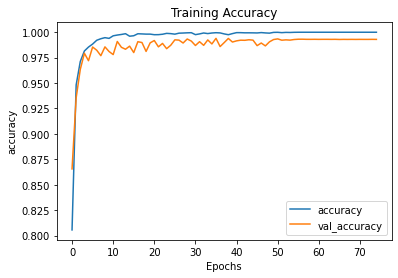

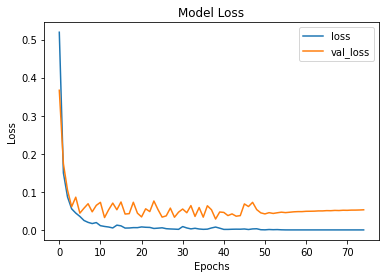

In [ ]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
print(classification_report(yyy_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     36187
           1       0.84      1.00      0.91      1157
           2       0.95      1.00      0.97      2912
           3       0.85      1.00      0.92       317
           4       0.98      1.00      0.99      3204

    accuracy                           0.99     43777
   macro avg       0.92      1.00      0.96     43777
weighted avg       0.99      0.99      0.99     43777



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


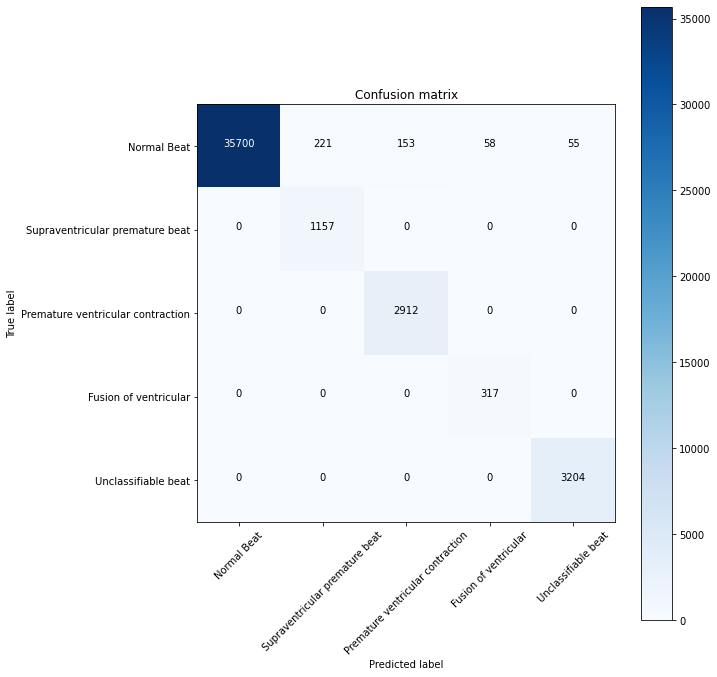

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yyy_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Normal Beat', 'Supraventricular premature beat',
       'Premature ventricular contraction', 'Fusion of ventricular',
       'Unclassifiable beat'],
                      title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(yyy_test, y_pred, pos_label=2)

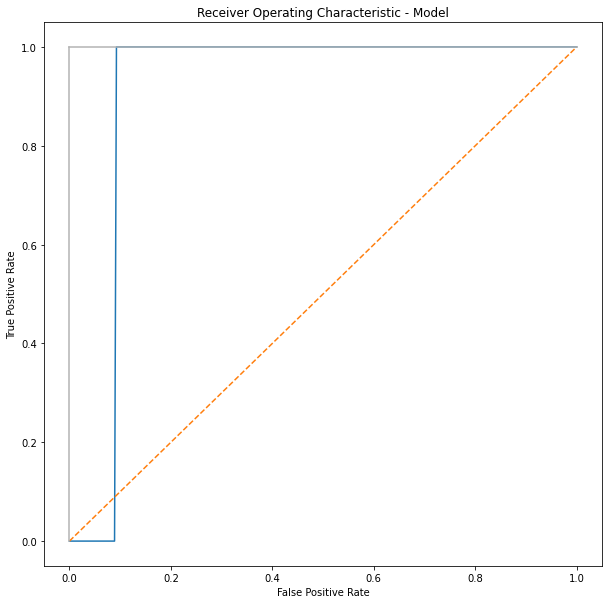

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Model')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
auc = metrics.auc(fpr, tpr)
print("Auc is : ")
print(auc )

Auc is : 
0.9092010277743791


In [ ]:
from IPython.display import FileLink
FileLink(r'./attention_model_.h5')

/kaggle/working/attention_model_.h5

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.reset_default_graph()


run_eagerly = True



def gradcam(model, x, index, layer_name):
   
    #with tf.Graph().as_default():
    model = tf.keras.models.load_model('./attention_model_.h5')
    preds = model.predict(x)
    #model._make_predict_function()
    pred_class = np.argmax(preds[index])
    
    
    #pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    
   
    pred_output = model.output[:, pred_class]
    
   
    # convolution layer
    last_conv_layer = model.get_layer(layer_name)
    
    #  convolution layer 
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    
    # feature map 
    #pooled_grads = K.sum(grads, axis=(0, 1, 2))
    pooled_grads = K.sum(grads, axis=(0, 1))
    
    # K.function()  `model.input` `pooled_grads` 
    # `last_conv_layer[0]` Tensorflow feed_dict
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[index]])
    
    #  x，feature map convolution layer 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, i] *= (pooled_grads_value[i])
        
    # feature map channel-wise 
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap, pred_class

In [ ]:
def heatmap_():
    heatmap_2d = np.expand_dims(heatmap,1)
    heatmap_2d = cv2.resize(heatmap_2d, (100,188))

    figure = plt.figure(figsize=(80,4))
    ax = figure.add_subplot(111)
    x = np.arange(0, 188, 1)
    ax.plot(x, data*100)
    ax.imshow(np.transpose(heatmap_2d), cmap="Oranges", extent=[0, 188, -10, 120])
    ax.autoscale(False)
    ax.set_xlim(0, 187)
    ax.set_ylim(-10, 110)
    ax.set_title(title)
    plt.show()

In [ ]:
def heatmap_3x():
    def preprocess_heatmap(heatmap):
        heatmap_2d = np.expand_dims(heatmap,1)
        heatmap_2d = cv2.resize(heatmap_2d, (100,186))
        heatmap_2d = np.transpose(heatmap_2d)
        return heatmap_2d

    fig, ax = plt.subplots(1,len(name_list)+1,figsize=(20,4))
    x = np.arange(0, 186, 1)
    Collect_attention = list()
    for i in range(1,len(name_list)+1):
        ax[i].plot(x, data*100)
        heatmap_2d = preprocess_heatmap(Collect_heatmap[i-1])
        Collect_attention.append(heatmap_2d[0])
        ax[i].imshow(heatmap_2d, cmap="Oranges", extent=[0, 186, -10, 120])
        ax[i].set_xlim(0, 187)
        ax[i].set_ylim(-10, 110)
        ax[i].set_title(name_list[i-1])
    ax[0].plot(x, data, label="ECG")
    for i in range(len(name_list)):
        ax[0].set_title(title)
        ax[0].plot(x, Collect_attention[i]/np.max(Collect_attention[i]), label=name_list[i])
        ax[0].set_ylim(-0.2, 1)
    ax[0].legend()

    plt.show()

In [ ]:
X_display = np.array(X_display).astype(float)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
y_display = y_display.tolist()

In [ ]:
from tensorflow import keras
model_layer = keras.models.load_model('./attention_model_.h5')

2022-07-26 12:31:13.868775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:31:13.869846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:31:13.870475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:31:13.871133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:31:13.871657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [ ]:
for i, layer in enumerate(model_layer.layers):
    print(i, layer.name, layer.output_shape)

0 input_1 [(None, 186, 1)]
1 conv1d (None, 182, 64)
2 activation (None, 182, 64)
3 conv1d_1 (None, 178, 64)
4 activation_1 (None, 178, 64)
5 conv1d_2 (None, 174, 64)
6 activation_2 (None, 174, 64)
7 flatten (None, 11136)
8 dense (None, 512)
9 activation_3 (None, 512)
10 dense_1 (None, 256)
11 activation_4 (None, 256)
12 dense_2 (None, 5)


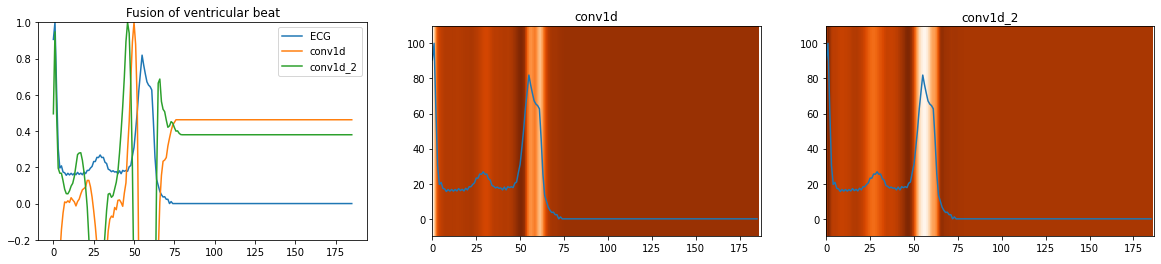

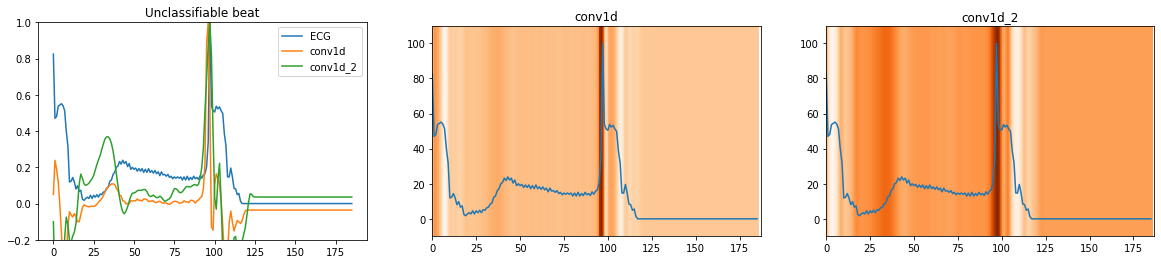

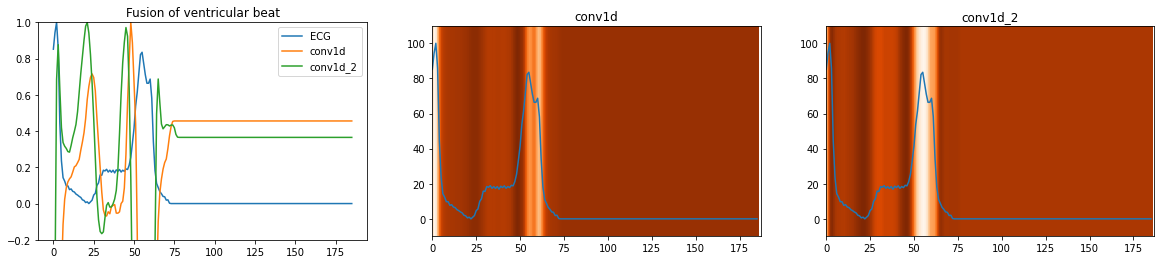

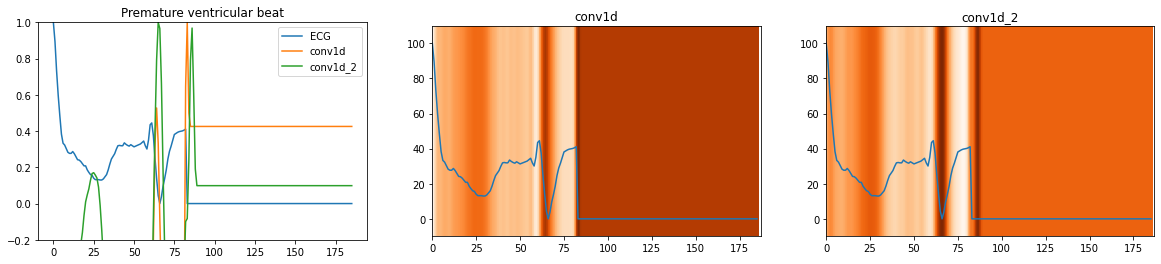

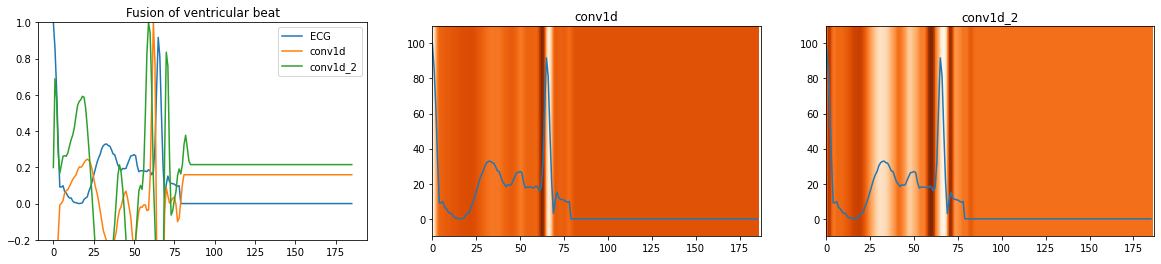

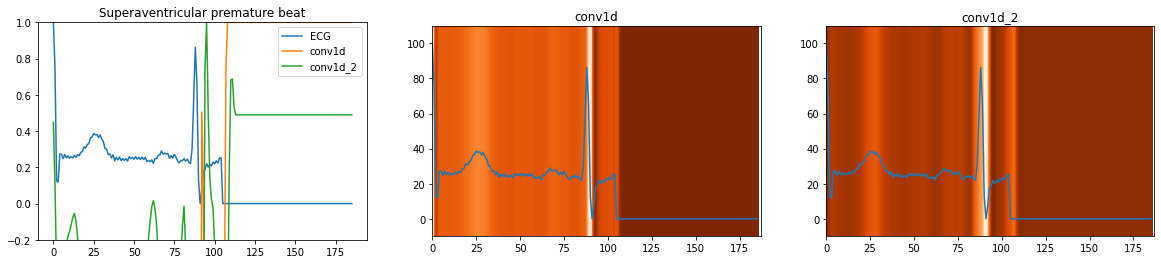

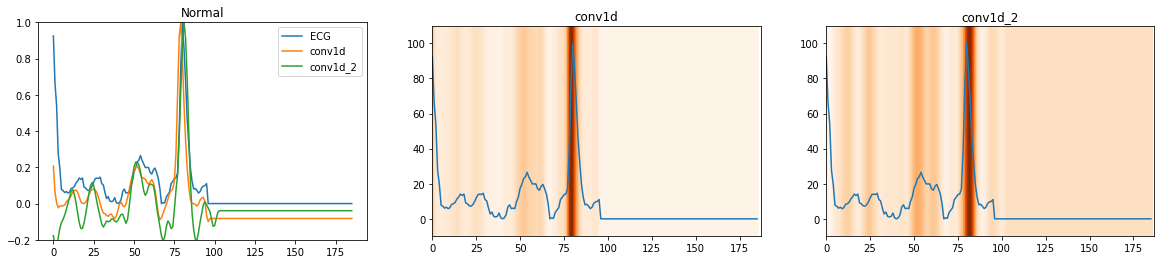

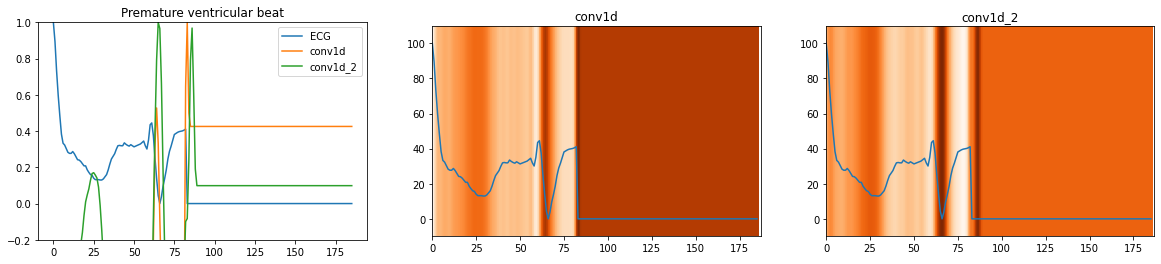

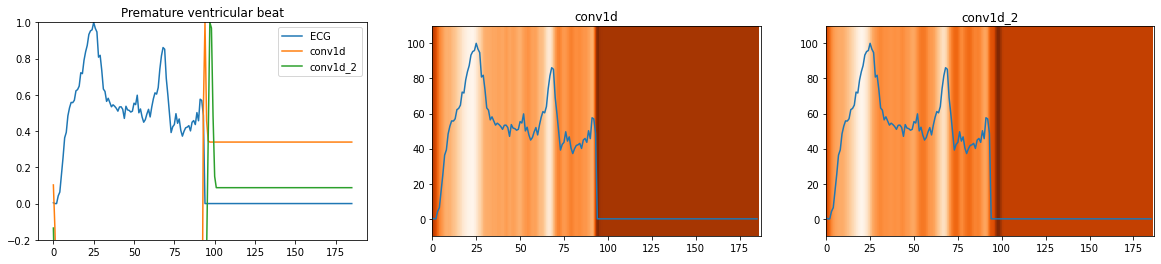

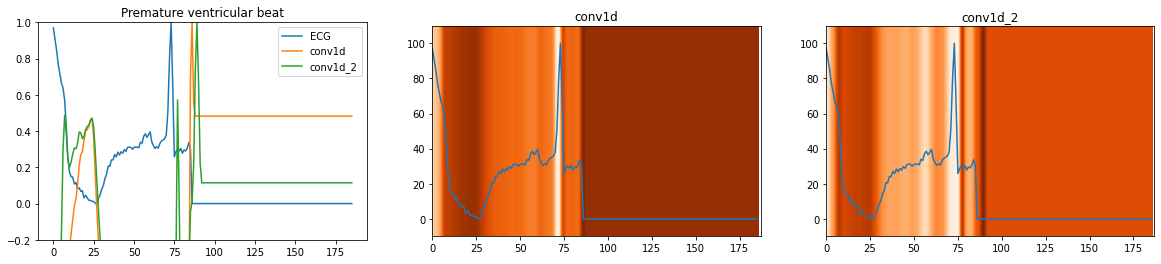

In [ ]:
for i in range(10):
    Collect_heatmap = list()
    index = np.random.randint(0,len(X_display))
    name_list = ["conv1d" ,"conv1d_2"]
    for name in name_list:
        heatmap, pred_class = gradcam(model, X_display, index, name)
        Collect_heatmap.append(heatmap)
    data = X_display[index]
    
    if int(y_display[index][0]==1): 
        title = "Normal"
    elif int(y_display[index][1]==1):
        title = "Superaventricular premature beat"
    elif int(y_display[index][2]==1):
        title = "Premature ventricular beat"
    elif int(y_display[index][3]==1):
        title = "Fusion of ventricular beat"
    elif int(y_display[index][4]==1):
        title = "Unclassifiable beat"
   
   
    heatmap_3x()